# Lecture 1: introduction to `qibo`

<center><img src="../figures/dall-e/merlion_qibo.png" alt="drawing" width="400"/></center>
<center><strong>Fig. 1:</strong> The merlion learning Qibo [DALL-E].</center>

### Introduction

During this course we are going to use `Qibo`, an open source framework for quantum computing. It provides us with an high level language which can be used to implement algorithms with both circuit-based and adiabatic computation approaches and, once the code is set up, it can be easily executed on various engines, including both classical and quantum hardware. 

<center><img src="../figures/qibo_ecosystem.svg" alt="drawing" width="800"/></center>

For more info about the whole framework one can have a look to the [`qibo` webpage](https://qibo.science/).

### Setup
We start installing `qibo` and then importing some useful primitives.

In [ ]:
# if you don't have already qibo and qibojit installed in your computer
!pip install qibo
!pip install qibojit

A crucial step is the backend choice. In qibo four backends are provided, and can be used for different kind of applications.

<center><img src="./figures/backends.svg" alt="drawing" width="800"/></center>

The blue backends correspond to classical hardware, while the red one can be selected if we want to execute our algorithm directly on a quantum computer.

Since we want to do simulation here, we set the `qibojit` backend, which is the most suitable one if we want to run simulation with many qubits.

In [2]:
# some imports from qibo + numpy
import numpy as np

import qibo
from qibo import Circuit, gates, hamiltonians

In [3]:
# with the following line we set the desired backend
qibo.set_backend(backend="qibojit", platform="numba")

[Qibo 0.2.6|INFO|2024-03-25 19:44:59]: Using qibojit (numba) backend on /CPU:0


In [4]:
# if qibojit is selected, we can specify the number of classical threads to be used
qibo.set_threads(16)

### Build my first `qibo` circuit

Now we are ready to code our first quantum circuit using `qibo`.

In [5]:
# set the number of qubits
nqubits = 4

# we initialise the circuit using the Circuit class
c = Circuit(nqubits=nqubits)

print(c.draw())

q0: ─
q1: ─
q2: ─
q3: ─


Secondly, we add some gates to the circuit. A more detailed list of all the available gates can be found in the [`qibo` documentation](https://qibo.science/qibo/stable/api-reference/qibo.html#gates).

In [6]:
# let's add some gates

# hadamards
c.add(gates.H(q=0))
c.add(gates.H(q=1))

# pauli's
c.add(gates.Z(q=3))
c.add(gates.X(q=0))

# controlled gates
c.add(gates.CNOT(q0=0, q1=2))
c.add(gates.CZ(q0=2, q1=1))

# more freedom in controlling gates :)
c.add(gates.Y(q=1).controlled_by(2,3,0))

Once the circuit is completed, we can print some summary information.

In [7]:
# summary info
print(c.summary())

Circuit depth = 5
Total number of gates = 7
Number of qubits = 4
Most common gates:
h: 2
z: 1
x: 1
cx: 1
cz: 1
y: 1


In [8]:
# circuit visualization
print(c.draw())

q0: ─H─X─o───o─
q1: ─H───|─Z─Y─
q2: ─────X─o─o─
q3: ─Z───────o─


At this point we already can execute the circuit.
Note that, since we are playing with `nqubits = 4`, the final state will be a possible superposition of all the 4-bits combinations. We wrote a function in `scripts.utils` which can be used to create the list of all the possible bitstrings given the number of qubits:

In [10]:
# we defined some utils functions
from qiboedu.scripts.utils import generate_bitstring_combinations

# one of them is to generate bitstrings combinations
bitstrings = generate_bitstring_combinations(n=nqubits)

In [11]:
print(bitstrings)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


Let's execute the circuit and verify which is the final state we get after the execution.

In [12]:
# execute the circuit
print(c())

(0.5+0j)|0000> + (0.5+0j)|0100> + (0.5+0j)|1010> + (-0.5+0j)|1110>


In [13]:
# print the final state
print(c().state())

outcome = c()

[ 0.5+0.j -0. +0.j  0. +0.j -0. +0.j  0.5+0.j -0. +0.j -0. +0.j  0. -0.j
  0. +0.j -0. +0.j  0.5+0.j -0. +0.j  0. +0.j -0. +0.j -0.5+0.j -0. +0.j]


In this simple case we defined a circuit without adding measurement gates. What we get as result of such an execution is the exact state vector simulation of the final state.

Since we simulated the exact final state, we can also have access to the final amplitudes, and so to the probabilities of collect some of the states corresponding to the list of bitstrings.

In [14]:
# print probabilities from outcome
probs = outcome.probabilities()

print(probs)

[0.25 0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.25 0.   0.   0.
 0.25 0.  ]


We can visualize them together with the bitstrings

In [15]:
# print each bitstring side by side with its probability value
for i in range(len(bitstrings)):
    print(f"Prob of state {bitstrings[i]} = {probs[i]}")

Prob of state 0000 = 0.2499999999999999
Prob of state 0001 = 0.0
Prob of state 0010 = 0.0
Prob of state 0011 = 0.0
Prob of state 0100 = 0.2499999999999999
Prob of state 0101 = 0.0
Prob of state 0110 = 0.0
Prob of state 0111 = 0.0
Prob of state 1000 = 0.0
Prob of state 1001 = 0.0
Prob of state 1010 = 0.2499999999999999
Prob of state 1011 = 0.0
Prob of state 1100 = 0.0
Prob of state 1101 = 0.0
Prob of state 1110 = 0.2499999999999999
Prob of state 1111 = 0.0


#### Add measurements gates
We can, instead, add measurements gates in the end of the circuit, if we want to simulate a more realistic scenario affected by shot-noise.

With shot-noise we mean the natural variance of quantum system, due to the fact that we need to measure the final state after applying the gates. In a realistic scenario we need to repeat the circuit execution many times and use the collected results to calculate an estimation of the probabilities.

In [16]:
# we initialise the same circuit using the Circuit class
c = Circuit(nqubits=nqubits)

# we add the same gates of before
# hadamards
c.add(gates.H(q=0))
c.add(gates.H(q=1))

# pauli's
c.add(gates.Z(q=3))
c.add(gates.X(q=0))

# controlled gates
c.add(gates.CNOT(q0=0, q1=2))
c.add(gates.CZ(q0=2, q1=1))

# more freedom in controlling gates :)
c.add(gates.Y(q=1).controlled_by(2,3,0))

# we also add measurements gates
c.add(gates.M(*range(nqubits)))

# print the new face of the circuit
print(c.draw())

q0: ─H─X─o───o─M─
q1: ─H───|─Z─Y─M─
q2: ─────X─o─o─M─
q3: ─Z───────o─M─


Again, we can execute the circuit and collect the outcome.

At this time, we also specify a number of shots.

In [17]:
# collect the outcome after setting a number of circuit shots
outcome = c(nshots=1000)

print(outcome)

(0.5+0j)|0000> + (0.5+0j)|0100> + (0.5+0j)|1010> + (-0.5+0j)|1110>


We can still collect the exact probabilities

In [18]:
# for all the qubits
outcome.probabilities()

array([0.25, 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.25,
       0.  , 0.  , 0.  , 0.25, 0.  ])

In [19]:
# or for some specific qubit of the system
outcome.probabilities(qubits=[0,3])

array([0.5, 0. , 0.5, 0. ])

We can also collect frequencies

In [20]:
# frequencies
# set binary=True if you want the amplitude binary notation
frequencies = outcome.frequencies()

print(frequencies)

Counter({'0100': 274, '1110': 250, '0000': 242, '1010': 234})


#### State visualization
We can use the `scripts.plotscripts.visualize_state` function, which takes as an argument the counter object you get calling `circuit(nshots=nshots).frequencies(binary=True)`.

In [22]:
# let's import the plotting function
from qiboedu.scripts.plotscripts import visualize_states

In [23]:
# we collect the counter object containing the frequencies
frequencies = outcome.frequencies(binary=True)

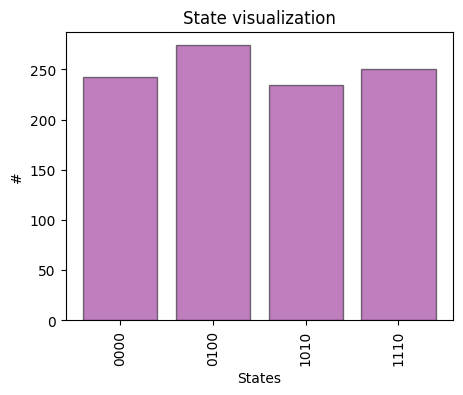

In [24]:
# we call the plotting function
visualize_states(frequencies)

#### Combining circuits into a single circuit 

It is possible to sum together two or more circuits (with the same number of qubits) into one.

In [25]:
# initialize c1
c1 = Circuit(3)
c1.add(gates.H(0))
c1.add(gates.CNOT(1,0))
c1.add(gates.Z(1))

# initialize c2
c2 = Circuit(3)
c2.add(gates.H(2))
c2.add(gates.Z(1))
c2.add(gates.Y(1))
c2.add(gates.CZ(2,1))

# let's print them
print(f"Circuit n1:\n{c1.draw()}\n")
print(f"Circuit n2:\n{c2.draw()}\n")

# combine them into a single circuit
c = c1 + c2

# print the final circuit
print(c.draw())

Circuit n1:
q0: ─H─X───
q1: ───o─Z─
q2: ───────

Circuit n2:
q0: ───────
q1: ─Z─Y─Z─
q2: ─H───o─

q0: ─H─X─────────
q1: ───o─Z─Z─Y─Z─
q2: ─────H─────o─


#### Let's simulate some entanglement

We can simulate the smallest entangling system in order to reproduce one of the Bell's states

$$ |b_1\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}} \\. $$

To do this, we need to create a two-qubit circuit, lead one of the two qubits to a superposed state using an Hadamard gate and then apply a controlled-NOT gate to the second qubit using the superposed one as control.

In [26]:
# two qubit circuit to simulate the first Bell's state
c = Circuit(2)
c.add(gates.H(0))
c.add(gates.CNOT(q0=0, q1=1))
c.add(gates.M(*range(2)))

MeasurementResult(qubits=(0, 1), nshots=0)

In [27]:
print(c(nshots=1000))

(0.70711+0j)|00> + (0.70711+0j)|11>


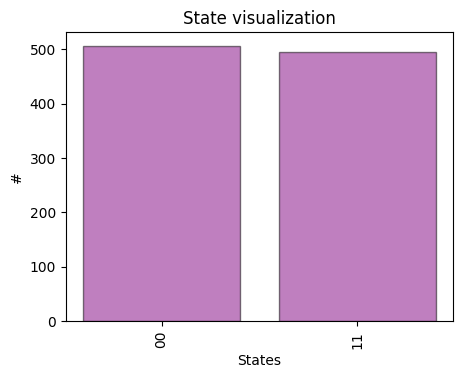

In [28]:
# collect outcome and frequencies
freq = c(nshots=1000).frequencies(binary=True)

# visualize it
visualize_states(freq)

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> implement the quantum circuits needed to prepare the other three Bell's states:
    $$ |b_2\rangle = \frac{|00\rangle - |11\rangle}{\sqrt{2}},\qquad |b_3\rangle = \frac{|10\rangle + |01\rangle}{\sqrt{2}},\qquad |b_4\rangle = \frac{|01\rangle - |10\rangle}{\sqrt{2}} \\. $$
</div>

### Parametrized gates

We can use parametric gates to manipulate the quantum state with some more freedom. 

The most commonly used parametric gates are rotations $R_k(\theta) = \exp [ -i \theta \sigma_k ] $, where $\sigma_k$ is one of the components of the Pauli's vector: $\vec{\sigma}=(I, \sigma_x, \sigma_y, \sigma_z)$.

In [29]:
# a fancier quantum circuit
nqubits = 2
nlayers = 2

c = Circuit(nqubits=nqubits)

for l in range(nlayers):
    for q in range(nqubits):
        # NOTE: the angles are set to zero here!
        c.add(gates.RY(q=q, theta=0))
        c.add(gates.RZ(q=q, theta=0))
    c.add(gates.CNOT(q0=0, q1=nqubits-1))
c.add(gates.M(*range(nqubits)))

print(c.draw())

q0: ─RY─RZ─o─RY─RZ─o─M─
q1: ─RY─RZ─X─RY─RZ─X─M─


All the rotational angles are now set to zero, and the final state is equal to the initial state (which is $|0\rangle^{\otimes N}$ by default). We can play with the angles to modify the final state.

(1+0j)|00>


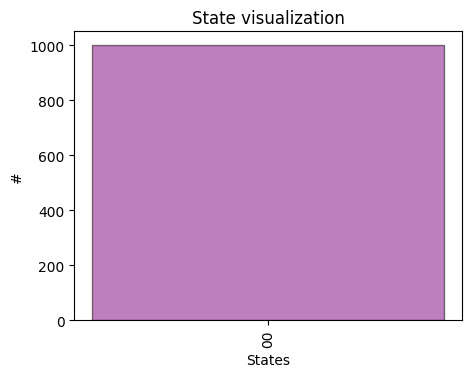

In [30]:
# execute the circuit and collect frequencies
outcome = c(nshots=1000)
freq = outcome.frequencies()

print(outcome)
# visualize the |0> state
visualize_states(freq)

In [31]:
# visualize the current parameters (angles)
initial_angles = c.get_parameters()

# get nparams
nparams = len(initial_angles)

print(initial_angles)

[(0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,)]


In [32]:
# generate a new random list of parameters
# after fixing numpy seed
np.random.seed(42)
angles = np.random.randn(nparams)

# set the parameters into the circuit
c.set_parameters(angles)

In [33]:
# visualize the new parameters
c.get_parameters()

[(0.4967141530112327,),
 (-0.13826430117118466,),
 (0.6476885381006925,),
 (1.5230298564080254,),
 (-0.23415337472333597,),
 (-0.23413695694918055,),
 (1.5792128155073915,),
 (0.7674347291529088,)]

(0.18227-0.62249j)|00> + (0.70785+0.08597j)|01> + (0.08842-0.03306j)|10> + (0.01107+0.24861j)|11>


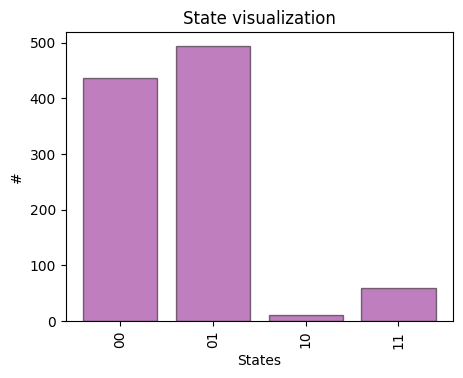

In [34]:
# execute, collect frequencies and visualize the state
outcome = c(nshots=1000)
freq = outcome.frequencies()

print(outcome)
visualize_states(freq)

### Hamiltonians

As final introductory step, let's see how to define and use an hamiltonian in Qibo.
We store a set of precomputed hamiltonians, which can be called and used to compute expectation values on the states we manipulate using circuits.

As a simple example, let's consider the following

In [35]:
# define an hamiltonian
h = hamiltonians.TFIM(2)

In [38]:
# visualize its matrix form
matrix = h.matrix
print(matrix, "\n")

# some properties: eigenvalues, eigenvectors, ground state
print(h.eigenvalues(), "\n")
print(h.eigenvectors(), "\n")
print(h.ground_state())

[[-2.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j  2.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j  2.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -2.-0.j]] 

[-2. -2.  2.  2.] 

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]] 

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


We can calculate the expectation value of an hamiltonian over a target state.
We are going to use the final state $|\psi\rangle$ we obtain by executing the above circuit composted of rotations.

In [37]:
# compute the expectation < psi | H | psi >
h.expectation(c().state())

0.06941692176323623